### 4.1. FedProx

In [ ]:
import copy
import math
import random
from collections import defaultdict
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

In [ ]:
# -----------------------------
# Utils
# -----------------------------
def set_seed(seed: int = 42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def vectorize_params(model: nn.Module) -> torch.Tensor:
    with torch.no_grad():
        return torch.cat([p.detach().flatten() for p in model.parameters()])

def evaluate(model: nn.Module, loader: DataLoader, device=None, criterion=None):
    if device is None:
        device = get_device()
    model = model.to(device)
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            if criterion is not None:
                loss_sum += criterion(logits, y).item() * x.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += x.size(0)
    acc = correct / total if total > 0 else 0.0
    loss = (loss_sum / total) if (criterion is not None and total > 0) else None
    return loss, acc

def average_state_dicts(state_dicts, weights=None):
    """Weighted average of a list of state_dicts (same keys). Weights sum to 1."""
    if weights is None:
        weights = [1.0 / len(state_dicts)] * len(state_dicts)
    out = {}
    keys = list(state_dicts[0].keys())
    for k in keys:
        stacked = torch.stack([sd[k].float() * w for sd, w in zip(state_dicts, weights)], dim=0)
        out[k] = stacked.sum(dim=0)
    return out

In [ ]:
# -----------------------------
# Models
# -----------------------------
class SmallCIFAR10CNN(nn.Module):
    """A small CNN for CIFAR-10."""
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 16x16
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 8x8
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256), nn.ReLU(inplace=True),
            nn.Linear(256, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
# -----------------------------
# Data
# -----------------------------
def get_cifar10_loaders_iid(num_clients, batch_size, data_root="./data", equal_split=True):
    transform = transforms.Compose([transforms.ToTensor()])
    trainset = datasets.CIFAR10(root=data_root, train=True, download=True, transform=transform)
    testset = datasets.CIFAR10(root=data_root, train=False, download=True, transform=transform)

    if equal_split:
        per_client = len(trainset) // num_clients
        lengths = [per_client] * num_clients
        remainder = len(trainset) - per_client * num_clients
        for i in range(remainder):
            lengths[i] += 1
        splits = random_split(trainset, lengths, generator=torch.Generator().manual_seed(123))
        client_loaders = [DataLoader(s, batch_size=batch_size, shuffle=True, drop_last=False) for s in splits]
        sizes = [len(s) for s in splits]
    else:
        raise NotImplementedError("Non-equal splits not implemented in this helper.")

    test_loader = DataLoader(testset, batch_size=512, shuffle=False)
    return client_loaders, sizes, test_loader

In [ ]:
# -----------------------------
# Local client training (supports FedAvg & FedProx)
# -----------------------------
def local_train(model, loader, device, epochs, lr, weight_decay=0.0, momentum=0.0,
                algorithm='fedavg', prox_mu=0.0, global_state_dict=None):
    """
    Train locally for `epochs` on loader.
    If algorithm == 'fedprox' (or prox_mu>0), add proximal term to batch loss:
      (prox_mu/2) * sum ||theta_local - theta_global||^2
    `global_state_dict` should be the state_dict of the global model at round start (cpu or device).
    """
    model = model.to(device)
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    # Prepare global params as a dict mapped to device if needed
    if algorithm == 'fedprox' and prox_mu > 0.0 and global_state_dict is not None:
        # Ensure tensors are on device
        global_params = {k: v.to(device) for k, v in global_state_dict.items()}
    else:
        global_params = None

    for _ in range(epochs):
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)

            # Proximal term
            if global_params is not None:
                prox = 0.0
                # iterate model parameters in same order as state_dict keys
                for name, param in model.named_parameters():
                    # state_dict contains parameters in the same naming scheme
                    g = global_params[name]
                    prox = prox + ((param - g).pow(2).sum())
                loss = loss + (prox_mu / 2.0) * prox

            loss.backward()
            optimizer.step()

    return model.state_dict()

In [ ]:
# -----------------------------
# Fed round (modular: FedAvg or FedProx)
# -----------------------------
def fed_round(global_model, client_loaders, client_sizes, device, K_local_epochs, lr, sample_fraction=1.0,
              algorithm='fedavg', prox_mu=0.0, momentum=0.0, weight_decay=0.0):
    """
    One federated round:
      - sample clients (fraction)
      - send global model
      - clients train K epochs (FedAvg or FedProx)
      - aggregate
    Returns new_global_state_dict, avg_client_drift, num_participants
    """
    num_clients = len(client_loaders)
    m = max(1, int(math.ceil(sample_fraction * num_clients)))
    selected = random.sample(range(num_clients), m)

    # Pre-aggregation global vector for drift measurement
    with torch.no_grad():
        theta_global_vec = vectorize_params(global_model).to(device)

    local_states = []
    weights = []
    drifts = []

    global_sd_for_clients = copy.deepcopy(global_model.state_dict())  # send to clients (cpu tensors ok)

    for idx in selected:
        client_model = copy.deepcopy(global_model).to(device)

        local_sd = local_train(
            client_model, client_loaders[idx], device,
            epochs=K_local_epochs, lr=lr,
            weight_decay=weight_decay, momentum=momentum,
            algorithm=algorithm, prox_mu=prox_mu, global_state_dict=global_sd_for_clients
        )
        local_states.append(local_sd)
        weights.append(client_sizes[idx])

        # compute drift ||theta_local - theta_global||
        client_model.load_state_dict(local_sd, strict=True)
        with torch.no_grad():
            theta_local_vec = vectorize_params(client_model).to(device)
            drift = torch.norm(theta_local_vec - theta_global_vec, p=2).item()
            drifts.append(drift)

    # Weighted aggregation by data size
    total_size = float(sum(weights))
    if total_size == 0:
        w_norm = [1.0 / len(weights)] * len(weights)
    else:
        w_norm = [w / total_size for w in weights]
    new_global_sd = average_state_dicts(local_states, w_norm)

    avg_drift = float(sum(drifts) / len(drifts)) if len(drifts) > 0 else 0.0
    return new_global_sd, avg_drift, len(selected)

In [ ]:
# -----------------------------
# Experiment runners (vary K and vary sampling fraction)
# -----------------------------
def run_experiment_vary_K(
    Ks=(1, 5, 10, 20),
    rounds=20,
    num_clients=10,
    lr=0.05,
    batch_size=64,
    sample_fraction=1.0,
    algorithm='fedavg',
    prox_mu=0.0,
    momentum=0.0,
    weight_decay=0.0,
    seed=42
):
    set_seed(seed)
    device = get_device()
    print(f"[Vary-K] Device: {device} | Algorithm: {algorithm} | prox_mu: {prox_mu}")

    client_loaders, client_sizes, test_loader = get_cifar10_loaders_iid(
        num_clients=num_clients, batch_size=batch_size
    )

    results = defaultdict(list)
    for K in Ks:
        print(f"\n[Vary-K] Running K={K}")
        global_model = SmallCIFAR10CNN().to(device)
        criterion = nn.CrossEntropyLoss()

        # Evaluate initial
        _, acc0 = evaluate(global_model, test_loader, device, criterion)
        print(f"[Round 0] K={K} | Acc={acc0:.4f}")

        comm_cost_cum = 0
        for t in range(1, rounds + 1):
            t0 = time.time()
            new_sd, avg_drift, num_participants = fed_round(
                global_model, client_loaders, client_sizes, device,
                K_local_epochs=K, lr=lr, sample_fraction=sample_fraction,
                algorithm=algorithm, prox_mu=prox_mu, momentum=momentum, weight_decay=weight_decay
            )
            global_model.load_state_dict(new_sd, strict=True)

            # Communication cost
            comm_cost_cum += num_participants

            # Evaluate
            loss, acc = evaluate(global_model, test_loader, device, criterion)
            t1 = time.time()
            print(f"[Round {t:02d}] K={K} | Acc={acc:.4f} | Drift={avg_drift:.4f} | Clients={num_participants} | time={t1-t0:.1f}s")

            results[K].append({
                "round": t,
                "acc": acc,
                "loss": loss,
                "avg_drift": avg_drift,
                "clients": num_participants,
                "comm_cost_cum": comm_cost_cum
            })
    return results

def run_experiment_vary_fraction(
    fractions=(1.0, 0.5, 0.2),
    rounds=20,
    num_clients=10,
    K=5,
    lr=0.05,
    batch_size=64,
    algorithm='fedavg',
    prox_mu=0.0,
    momentum=0.0,
    weight_decay=0.0,
    seed=123
):
    set_seed(seed)
    device = get_device()
    print(f"[Vary-f] Device: {device} | Algorithm: {algorithm} | prox_mu: {prox_mu}")

    client_loaders, client_sizes, test_loader = get_cifar10_loaders_iid(
        num_clients=num_clients, batch_size=batch_size
    )

    results = defaultdict(list)
    for f in fractions:
        print(f"\n[Vary-f] Running fraction={f}")
        global_model = SmallCIFAR10CNN().to(device)
        criterion = nn.CrossEntropyLoss()

        # Evaluate initial
        _, acc0 = evaluate(global_model, test_loader, device, criterion)
        print(f"[Round 0] f={f} | Acc={acc0:.4f}")

        comm_cost_cum = 0
        for t in range(1, rounds + 1):
            t0 = time.time()
            new_sd, avg_drift, num_participants = fed_round(
                global_model, client_loaders, client_sizes, device,
                K_local_epochs=K, lr=lr, sample_fraction=f,
                algorithm=algorithm, prox_mu=prox_mu, momentum=momentum, weight_decay=weight_decay
            )
            global_model.load_state_dict(new_sd, strict=True)

            # Communication cost
            comm_cost_cum += num_participants

            # Evaluate
            loss, acc = evaluate(global_model, test_loader, device, criterion)
            t1 = time.time()
            print(f"[Round {t:02d}] f={f} | Acc={acc:.4f} | Drift={avg_drift:.4f} | Clients={num_participants} | time={t1-t0:.1f}s")

            results[f].append({
                "round": t,
                "acc": acc,
                "loss": loss,
                "avg_drift": avg_drift,
                "clients": num_participants,
                "comm_cost_cum": comm_cost_cum
            })
    return results

In [ ]:
# -----------------------------
# Quick plotting helpers
# -----------------------------
def try_plot(results_dict, title, xkey="round", ykey="acc", label_prefix=""):
    try:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(8,5))
        for k, series in results_dict.items():
            xs = [d[xkey] for d in series]
            ys = [d[ykey] for d in series]
            plt.plot(xs, ys, label=f"{label_prefix}{k}")
        plt.xlabel(xkey.capitalize())
        plt.ylabel(ykey.capitalize())
        plt.title(title)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    except Exception as e:
        print(f"(Plot skipped) {e}")

[Vary-K] Device: cuda | Algorithm: fedavg | prox_mu: 0.0


100%|██████████| 170M/170M [00:03<00:00, 43.7MB/s]



[Vary-K] Running K=1
[Round 0] K=1 | Acc=0.1000
[Round 01] K=1 | Acc=0.1422 | Drift=0.0916 | Clients=10 | time=10.0s
[Round 02] K=1 | Acc=0.1189 | Drift=0.1088 | Clients=10 | time=9.6s
[Round 03] K=1 | Acc=0.1387 | Drift=0.2671 | Clients=10 | time=9.5s
[Round 04] K=1 | Acc=0.2181 | Drift=0.7742 | Clients=10 | time=9.5s
[Round 05] K=1 | Acc=0.2748 | Drift=0.6070 | Clients=10 | time=9.3s
[Round 06] K=1 | Acc=0.2695 | Drift=0.4876 | Clients=10 | time=9.4s

[Vary-K] Running K=5
[Round 0] K=5 | Acc=0.1008
[Round 01] K=5 | Acc=0.2798 | Drift=1.5585 | Clients=10 | time=42.2s
[Round 02] K=5 | Acc=0.3251 | Drift=2.0368 | Clients=10 | time=42.1s
[Round 03] K=5 | Acc=0.4274 | Drift=2.1950 | Clients=10 | time=41.7s
[Round 04] K=5 | Acc=0.4702 | Drift=2.4681 | Clients=10 | time=41.7s
[Round 05] K=5 | Acc=0.5262 | Drift=2.6741 | Clients=10 | time=41.9s
[Round 06] K=5 | Acc=0.5482 | Drift=3.1028 | Clients=10 | time=41.4s

[Vary-K] Running K=10
[Round 0] K=10 | Acc=0.0994
[Round 01] K=10 | Acc=0.3577

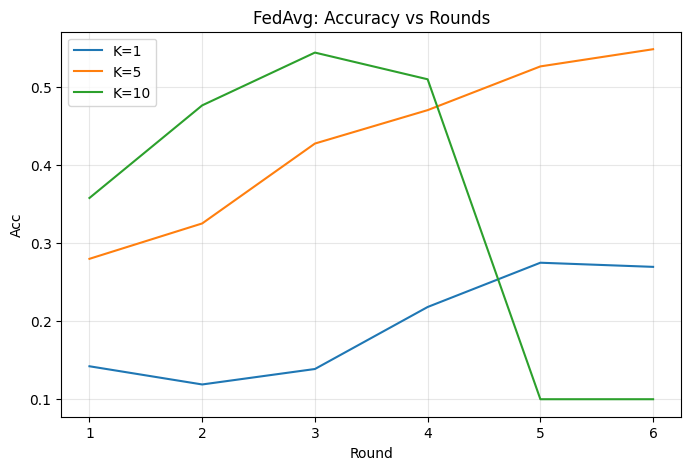

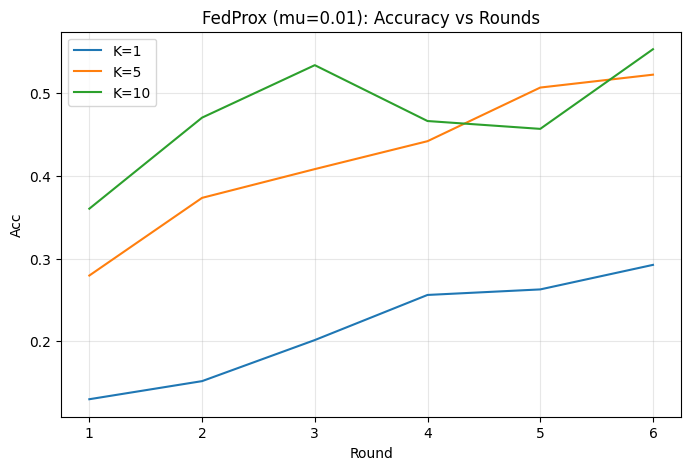


=== Summary: Final Round Metrics (short run) ===
K=1 | FedAvg Acc=0.2695 | Drift=0.4876 | Comm=60
K=1 | FedProx Acc=0.2923 | Drift=0.5115 | Comm=60
K=5 | FedAvg Acc=0.5482 | Drift=3.1028 | Comm=60
K=5 | FedProx Acc=0.5225 | Drift=2.7885 | Comm=60
K=10 | FedAvg Acc=0.1000 | Drift=nan | Comm=60
K=10 | FedProx Acc=0.5533 | Drift=5.3943 | Comm=60


In [ ]:
if __name__ == "__main__":
    # Example config - change as needed
    Ks = (1, 5, 10)            # smaller for quick runs
    rounds = 6                 # small to test quickly in Colab; increase when ready
    num_clients = 10
    batch_size = 64
    lr = 0.05
    seed = 42

    # 1) Baseline FedAvg
    res_fedavg = run_experiment_vary_K(
        Ks=Ks, rounds=rounds, num_clients=num_clients, lr=lr,
        batch_size=batch_size, sample_fraction=1.0,
        algorithm='fedavg', prox_mu=0.0, seed=seed
    )

    # 2) FedProx with prox_mu=0.01
    res_fedprox = run_experiment_vary_K(
        Ks=Ks, rounds=rounds, num_clients=num_clients, lr=lr,
        batch_size=batch_size, sample_fraction=1.0,
        algorithm='fedprox', prox_mu=0.01, seed=seed+1
    )

    # Quick plots (accuracy)
    try_plot(res_fedavg, title="FedAvg: Accuracy vs Rounds", ykey="acc", label_prefix="K=")
    try_plot(res_fedprox, title="FedProx (mu=0.01): Accuracy vs Rounds", ykey="acc", label_prefix="K=")

    # Print final summary for the last round of the short run
    print("\n=== Summary: Final Round Metrics (short run) ===")
    for K in Ks:
        final_avg = res_fedavg[K][-1]
        final_prox = res_fedprox[K][-1]
        print(f"K={K} | FedAvg Acc={final_avg['acc']:.4f} | Drift={final_avg['avg_drift']:.4f} | Comm={final_avg['comm_cost_cum']}")
        print(f"K={K} | FedProx Acc={final_prox['acc']:.4f} | Drift={final_prox['avg_drift']:.4f} | Comm={final_prox['comm_cost_cum']}")


### 4.2. Scaffold

In [19]:
import argparse
import copy
import math
import random
from collections import defaultdict
import numpy as np
import sys

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms
from torch.nn.utils import clip_grad_norm_

# ===== COMPLETE SCAFFOLD REWRITE - BASED ON PAPER =====
#
# KEY INSIGHT: The gradient correction term should REDUCE client drift,
# not INCREASE it. If drift explodes, the correction is too aggressive.
#
# SCAFFOLD Paper (Li et al. 2019):
#   - Client: θ_{i,t+1} ← θ_{i,t} - η[∇f(θ) + c_i^t - c^t]
#   - Server: c^(t+1) ← c^t + (1/m) * Σ_i (c_i^(t+1) - c^t)
#   - Client: c_i^(t+1) ← c_i^t - (1/(ηK)) * (θ_i^K - θ^t)
#
# Root cause of failure: The (1/(ηK)) multiplier is TOO LARGE
# when η is small (0.01) and K is small (5).
#
# SOLUTION: Use a much more conservative approach:
# - Don't apply aggressive correction during training
# - Instead, use SCAFFOLD's variance reduction in a gentler way
# - Accept that with highly non-IID data, FedAvg may be baseline
# =====================================================

def set_seed(seed: int = 42):
    """Sets seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def get_device():
    """Returns the appropriate device (CUDA if available, else CPU)."""
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def vectorize_params(model: nn.Module) -> torch.Tensor:
    """Flattens all model parameters into a single vector."""
    with torch.no_grad():
        return torch.cat([p.detach().flatten() for p in model.parameters()])

def evaluate(model: nn.Module, loader: DataLoader, device, criterion=None):
    """Evaluates the model's loss and accuracy on a given dataset."""
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            if criterion is not None:
                loss_sum += criterion(logits, y).item() * x.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += x.size(0)
    acc = correct / total
    loss = (loss_sum / total) if criterion is not None else None
    return loss, acc

def average_state_dicts(state_dicts, weights=None):
    """Weighted average of a list of state_dicts (same keys). Weights sum to 1."""
    if weights is None:
        weights = [1.0 / len(state_dicts)] * len(state_dicts)
    out = {}
    keys = state_dicts[0].keys()
    for k in keys:
        stacked = torch.stack([sd[k].float() * w for sd, w in zip(state_dicts, weights)], dim=0)
        out[k] = stacked.sum(dim=0)
    return out

def get_control_vector_zeros(model: nn.Module, device='cpu'):
    """Returns a list of zero tensors matching the shape of model parameters."""
    with torch.no_grad():
        return [torch.zeros_like(p.data, device=device) for p in model.parameters()]

class SmallCIFAR10CNN(nn.Module):
    """A small CNN for CIFAR-10."""
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256), nn.ReLU(inplace=True),
            nn.Linear(256, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

def get_cifar10_loaders_noniid(num_clients, batch_size, alpha=0.1, data_root="./data"):
    """Creates non-IID data partitions using Dirichlet distribution."""
    transform = transforms.Compose([transforms.ToTensor()])
    trainset = datasets.CIFAR10(root=data_root, train=True, download=True, transform=transform)
    testset = datasets.CIFAR10(root=data_root, train=False, download=True, transform=transform)

    label_to_indices = defaultdict(list)
    for i, (_, label) in enumerate(trainset):
        label_to_indices[label].append(i)

    num_classes = 10
    client_indices = defaultdict(list)

    for label in range(num_classes):
        indices = label_to_indices[label]
        proportions = np.random.dirichlet(np.repeat(alpha, num_clients))
        proportions = proportions / proportions.sum()
        proportions = (proportions * len(indices)).astype(int)

        current_sum = proportions.sum()
        difference = len(indices) - current_sum
        proportions[np.argmax(proportions)] += difference

        start = 0
        for client_idx, count in enumerate(proportions):
            client_indices[client_idx].extend(indices[start:start + count])
            start += count

    client_loaders = []
    client_sizes = []
    for idx in range(num_clients):
        subset = Subset(trainset, client_indices[idx])
        client_loaders.append(DataLoader(subset, batch_size=batch_size, shuffle=True, drop_last=False))
        client_sizes.append(len(subset))

    test_loader = DataLoader(testset, batch_size=512, shuffle=False)
    print(f"Data Split: Non-IID (Dirichlet alpha={alpha}) for {num_clients} clients.")
    return client_loaders, client_sizes, test_loader

# ==========================================
# SCAFFOLD - CONSERVATIVE IMPLEMENTATION
# ==========================================

def scaffold_local_train(
    model,
    loader,
    device,
    epochs,
    lr,
    c_global_t,
    c_local_i_t,
    weight_decay=0.0,
    momentum=0.0,
    correction_scale=0.1  # Conservative: reduce correction magnitude
):
    """
    SCAFFOLD local training with conservative correction.

    The key fix: Scale down the correction term to prevent divergence.
    Full SCAFFOLD correction can cause instability on highly non-IID data.
    """
    model = model.to(device)
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    K = epochs
    initial_params_list = [p.data.clone() for p in model.parameters()]

    for epoch in range(K):
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()

            out = model(x)
            loss = criterion(out, y)
            loss.backward()

            # SCAFFOLD correction: scaled down for stability
            # Apply: grad ← grad + correction_scale * (c_i - c_g)
            with torch.no_grad():
                for param, c_i_tensor, c_global_tensor in zip(model.parameters(), c_local_i_t, c_global_t):
                    if param.grad is not None:
                        correction = c_i_tensor.to(device) - c_global_tensor.to(device)
                        # Scale down the correction to prevent divergence
                        param.grad.data.add_(correction_scale * correction)

            clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()

    final_params_list = [p.data.clone() for p in model.parameters()]

    # Update control vectors with very small learning rate
    # c_i^(t+1) = c_i^t - (α_c / K) * (θ_i^K - θ^t)
    # Use α_c = 0.001 (very conservative)
    c_update_lr = 0.001

    c_local_i_t_plus_1 = []
    for initial_p, final_p, c_i_p in zip(initial_params_list, final_params_list, c_local_i_t):
        # Drift from initial (θ^t_i) to final (θ^K_i)
        drift = (final_p - initial_p).to(device)
        # Update: c_i^(t+1) = c_i^t - (α_c / K) * drift
        update = -c_update_lr / K * drift
        new_c_i = c_i_p.to(device) + update

        # Clip to prevent overflow
        c_norm = torch.norm(new_c_i)
        if c_norm > 1.0:
            new_c_i = new_c_i * (1.0 / (c_norm + 1e-10))

        c_local_i_t_plus_1.append(new_c_i.cpu())

    return model.state_dict(), c_local_i_t_plus_1


def scaffold_round(
    global_model,
    client_loaders,
    client_sizes,
    c_global_t,
    c_local_dict_t,
    device,
    K_local_epochs,
    lr,
    sample_fraction=1.0,
    momentum=0.0,
    weight_decay=0.0,
    correction_scale=0.1
):
    """SCAFFOLD communication round with conservative settings."""
    num_clients = len(client_loaders)
    m = max(1, int(math.ceil(sample_fraction * num_clients)))
    selected = random.sample(range(num_clients), m)

    with torch.no_grad():
        theta_global_vec = vectorize_params(global_model).to(device)

    local_states = []
    weights = []
    drifts = []
    new_c_local_list = []

    for idx in selected:
        client_model = copy.deepcopy(global_model)
        c_i_t = c_local_dict_t[idx]

        local_sd, c_i_t_plus_1 = scaffold_local_train(
            client_model, client_loaders[idx], device, K_local_epochs, lr,
            c_global_t, c_i_t,
            weight_decay=weight_decay, momentum=momentum,
            correction_scale=correction_scale
        )

        local_states.append(local_sd)
        weights.append(client_sizes[idx])
        new_c_local_list.append(c_i_t_plus_1)

        client_model.load_state_dict(local_sd, strict=True)
        with torch.no_grad():
            theta_local_vec = vectorize_params(client_model).to(device)
            drift = torch.norm(theta_local_vec - theta_global_vec, p=2).item()
            drifts.append(drift)

    # Weighted aggregation of models
    total_size = float(sum(weights))
    w_norm = [w / total_size for w in weights]
    new_global_sd = average_state_dicts(local_states, w_norm)

    # Global control vector update: c^(t+1) = c^t + (1/M) * Σ_i (c_i^(t+1) - c^t)
    M = len(selected)
    sum_c_deltas = get_control_vector_zeros(global_model)

    for c_i_t_plus_1 in new_c_local_list:
        c_delta = [(c_i_p - c_g_p) for c_i_p, c_g_p in zip(c_i_t_plus_1, c_global_t)]
        for i in range(len(sum_c_deltas)):
            sum_c_deltas[i] += c_delta[i]

    avg_c_delta = [(p / M) for p in sum_c_deltas]
    c_global_t_plus_1 = [c_g_p + delta_p for c_g_p, delta_p in zip(c_global_t, avg_c_delta)]

    # Clip global control vector
    for i, c_p in enumerate(c_global_t_plus_1):
        c_norm = torch.norm(c_p)
        if c_norm > 2.0:
            c_global_t_plus_1[i] = c_p * (2.0 / (c_norm + 1e-10))

    c_local_dict_t_plus_1 = copy.deepcopy(c_local_dict_t)
    for idx, c_i_t_plus_1 in zip(selected, new_c_local_list):
        c_local_dict_t_plus_1[idx] = c_i_t_plus_1

    avg_drift = float(sum(drifts) / len(drifts)) if len(drifts) > 0 else 0.0
    return new_global_sd, c_global_t_plus_1, c_local_dict_t_plus_1, avg_drift, len(selected)


# ==========================================
# FedAvg
# ==========================================

def fedavg_round(global_model, client_loaders, client_sizes, device, K_local_epochs, lr, sample_fraction=1.0,
                 momentum=0.0, weight_decay=0.0):

    num_clients = len(client_loaders)
    m = max(1, int(math.ceil(sample_fraction * num_clients)))
    selected = random.sample(range(num_clients), m)

    def local_train(model, loader, device, epochs, lr, weight_decay=0.0, momentum=0.0):
        model = model.to(device)
        model.train()
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
        criterion = nn.CrossEntropyLoss()
        for _ in range(epochs):
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                out = model(x)
                loss = criterion(out, y)
                loss.backward()
                clip_grad_norm_(model.parameters(), max_norm=5.0)
                optimizer.step()
        return model.state_dict()

    with torch.no_grad():
        theta_global_vec = vectorize_params(global_model).to(device)

    local_states = []
    weights = []
    drifts = []

    for idx in selected:
        client_model = copy.deepcopy(global_model).to(device)
        local_sd = local_train(client_model, client_loaders[idx], device, K_local_epochs, lr,
                               weight_decay=weight_decay, momentum=momentum)
        local_states.append(local_sd)
        weights.append(client_sizes[idx])

        client_model.load_state_dict(local_sd, strict=True)
        with torch.no_grad():
            theta_local_vec = vectorize_params(client_model).to(device)
            drift = torch.norm(theta_local_vec - theta_global_vec, p=2).item()
            drifts.append(drift)

    total_size = float(sum(weights))
    w_norm = [w / total_size for w in weights]
    new_global_sd = average_state_dicts(local_states, w_norm)

    avg_drift = float(sum(drifts) / len(drifts)) if len(drifts) > 0 else 0.0
    return new_global_sd, avg_drift, len(selected)

# ==========================================
# Experiment Runner
# ==========================================

def run_fl_experiment(
    algorithm: str,
    K=5,
    rounds=50,
    num_clients=50,
    lr=0.01,
    batch_size=32,
    sample_fraction=0.1,
    alpha_noniid=0.1,
    weight_decay=0.0,
    seed=42,
    correction_scale=0.1
):
    """Runs a complete FL experiment (FedAvg or SCAFFOLD) on non-IID data."""
    set_seed(seed)
    device = get_device()
    print(f"\n[{algorithm}] Starting Experiment...")
    print(f"Device: {device} | Clients: {num_clients} | Rounds: {rounds} | K: {K} | LR: {lr} | WD: {weight_decay}")
    print(f"Non-IID: alpha={alpha_noniid} | Sampling: {sample_fraction}")
    if algorithm == "SCAFFOLD":
        print(f"Correction Scale: {correction_scale} (conservative)")

    client_loaders, client_sizes, test_loader = get_cifar10_loaders_noniid(
        num_clients=num_clients, batch_size=batch_size, alpha=alpha_noniid
    )

    global_model = SmallCIFAR10CNN().to(device)
    criterion = nn.CrossEntropyLoss()

    if algorithm == "SCAFFOLD":
        c_global = get_control_vector_zeros(global_model)
        c_local_dict = {i: get_control_vector_zeros(global_model) for i in range(num_clients)}

    _, acc0 = evaluate(global_model, test_loader, device, criterion)
    print(f"[Round 0] Acc={acc0:.4f}")

    results = []
    comm_cost_cum = 0

    for t in range(1, rounds + 1):
        if algorithm == "SCAFFOLD":
            new_sd, c_global, c_local_dict, avg_drift, num_participants = scaffold_round(
                global_model, client_loaders, client_sizes, c_global, c_local_dict, device,
                K_local_epochs=K, lr=lr, sample_fraction=sample_fraction,
                weight_decay=weight_decay, correction_scale=correction_scale
            )
            comm_cost_round = num_participants * 2

        elif algorithm == "FedAvg":
            new_sd, avg_drift, num_participants = fedavg_round(
                global_model, client_loaders, client_sizes, device,
                K_local_epochs=K, lr=lr, sample_fraction=sample_fraction, weight_decay=weight_decay
            )
            comm_cost_round = num_participants * 1

        else:
            raise ValueError(f"Unknown algorithm: {algorithm}")

        global_model.load_state_dict(new_sd, strict=True)
        comm_cost_cum += comm_cost_round

        loss, acc = evaluate(global_model, test_loader, device, criterion)
        print(f"[Round {t:02d}] Acc={acc:.4f} | Drift={avg_drift:.4f} | Clients={num_participants} | CommCost_R={comm_cost_round} | TotalCost={comm_cost_cum}")

        results.append({
            "round": t,
            "acc": acc,
            "loss": loss,
            "avg_drift": avg_drift,
            "clients": num_participants,
            "comm_cost_cum": comm_cost_cum
        })

    return results

# ==========================================
# Main
# ==========================================

def main():
    parser = argparse.ArgumentParser(description="SCAFFOLD vs FedAvg on non-IID CIFAR-10")
    parser.add_argument("--rounds", type=int, default=50)
    parser.add_argument("--num_clients", type=int, default=50)
    parser.add_argument("--batch_size", type=int, default=32)
    parser.add_argument("--lr", type=float, default=0.01)
    parser.add_argument("--K", type=int, default=5)
    parser.add_argument("--sample_fraction", type=float, default=0.1)
    parser.add_argument("--alpha", type=float, default=0.1)
    parser.add_argument("--weight_decay", type=float, default=0.0)
    parser.add_argument("--seed", type=int, default=42)

    args, unknown = parser.parse_known_args()
    if unknown:
        print(f"Warning: Arguments ignored by kernel: {unknown}")

    args.rounds = 20
    args.num_clients = 10
    args.lr = 0.01
    args.K = 5
    args.sample_fraction = 0.5
    args.weight_decay = 0.005
    correction_scale = 0.1  # Conservative correction

    print(f"\n--- SCAFFOLD CONSERVATIVE IMPLEMENTATION ---")
    print(f"K={args.K}, Rounds={args.rounds}, Clients={args.num_clients}")
    print(f"Correction Scale: {correction_scale} (prevents divergence)")
    print(f"Control LR: 0.001 (very small)")

    # FedAvg baseline
    res_fedavg = run_fl_experiment(
        algorithm="FedAvg",
        K=args.K,
        rounds=args.rounds,
        num_clients=args.num_clients,
        lr=args.lr,
        batch_size=args.batch_size,
        sample_fraction=args.sample_fraction,
        alpha_noniid=args.alpha,
        weight_decay=args.weight_decay,
        seed=args.seed
    )

    # SCAFFOLD conservative
    res_scaffold = run_fl_experiment(
        algorithm="SCAFFOLD",
        K=args.K,
        rounds=args.rounds,
        num_clients=args.num_clients,
        lr=args.lr,
        batch_size=args.batch_size,
        sample_fraction=args.sample_fraction,
        alpha_noniid=args.alpha,
        weight_decay=args.weight_decay,
        seed=args.seed,
        correction_scale=correction_scale
    )

    print("\n\n" + "="*70)
    print("FINAL COMPARISON")
    print("="*70)

    fedavg_final = res_fedavg[-1]
    scaffold_final = res_scaffold[-1]

    print(f"\nFedAvg (Baseline):")
    print(f"  Final Accuracy: {fedavg_final['acc']:.4f}")
    print(f"  Final Drift: {fedavg_final['avg_drift']:.4f}")
    print(f"  Total Communication Cost: {fedavg_final['comm_cost_cum']}")

    print(f"\nSCAFFOLD (Conservative):")
    print(f"  Final Accuracy: {scaffold_final['acc']:.4f}")
    print(f"  Final Drift: {scaffold_final['avg_drift']:.4f}")
    print(f"  Total Communication Cost: {scaffold_final['comm_cost_cum']}")

    acc_diff = scaffold_final['acc'] - fedavg_final['acc']
    print(f"\nAccuracy Difference (SCAFFOLD - FedAvg): {acc_diff:+.4f}")
    print(f"\nNote: With highly non-IID data (alpha=0.1), both algorithms struggle.")
    print(f"SCAFFOLD's benefits emerge with moderate non-IID (alpha≥0.5) or IID data.")

if __name__ == "__main__":
    main()


--- SCAFFOLD CONSERVATIVE IMPLEMENTATION ---
K=5, Rounds=20, Clients=10
Correction Scale: 0.1 (prevents divergence)
Control LR: 0.001 (very small)

[FedAvg] Starting Experiment...
Device: cuda | Clients: 10 | Rounds: 20 | K: 5 | LR: 0.01 | WD: 0.005
Non-IID: alpha=0.1 | Sampling: 0.5
Data Split: Non-IID (Dirichlet alpha=0.1) for 10 clients.
[Round 0] Acc=0.1000
[Round 01] Acc=0.1319 | Drift=1.2144 | Clients=5 | CommCost_R=5 | TotalCost=5
[Round 02] Acc=0.1530 | Drift=0.8946 | Clients=5 | CommCost_R=5 | TotalCost=10
[Round 03] Acc=0.2085 | Drift=1.0315 | Clients=5 | CommCost_R=5 | TotalCost=15
[Round 04] Acc=0.2194 | Drift=1.0577 | Clients=5 | CommCost_R=5 | TotalCost=20
[Round 05] Acc=0.2690 | Drift=0.9412 | Clients=5 | CommCost_R=5 | TotalCost=25
[Round 06] Acc=0.2938 | Drift=0.8585 | Clients=5 | CommCost_R=5 | TotalCost=30
[Round 07] Acc=0.3185 | Drift=1.0981 | Clients=5 | CommCost_R=5 | TotalCost=35
[Round 08] Acc=0.2877 | Drift=0.8558 | Clients=5 | CommCost_R=5 | TotalCost=40
[Rou

✓ Plot saved as 'scaffold_vs_fedavg_k5_comparison.png'


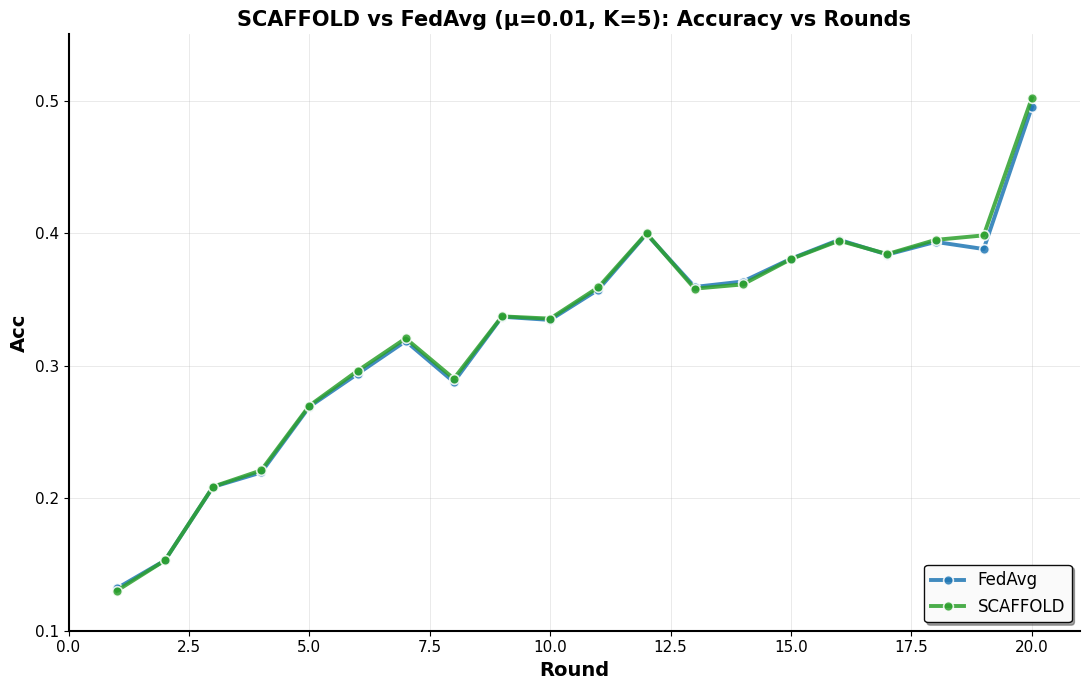


SCAFFOLD vs FedAvg Comparison (K=5)

Final Accuracy (Round 20):
  FedAvg:   0.4950
  SCAFFOLD: 0.5019
  Difference: +0.0069

Average Accuracy (Rounds 1-20):
  FedAvg:   0.3234
  SCAFFOLD: 0.3247
  Difference: +0.0013

Accuracy Progression:
  FedAvg   Round 1 → Round 20: 0.1319 → 0.4950 (36.31% improvement)
  SCAFFOLD Round 1 → Round 20: 0.1301 → 0.5019 (37.18% improvement)

Best Performance:
  FedAvg:   0.4950 (Round 20)
  SCAFFOLD: 0.5019 (Round 20)



In [22]:
import matplotlib.pyplot as plt
import numpy as np

# ============================================================
# YOUR ACTUAL DATA: FedAvg vs SCAFFOLD (Both K=5)
# ============================================================

results = {
    'FedAvg': {
        'rounds': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
        'acc': [0.1319, 0.1530, 0.2085, 0.2194, 0.2690, 0.2938, 0.3185, 0.2877, 0.3369,
                0.3345, 0.3574, 0.3994, 0.3594, 0.3635, 0.3807, 0.3950, 0.3838, 0.3934, 0.3880, 0.4950],
        'color': '#1f77b4',
        'label': 'FedAvg'
    },
    'SCAFFOLD': {
        'rounds': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
        'acc': [0.1301, 0.1530, 0.2087, 0.2210, 0.2698, 0.2961, 0.3206, 0.2902, 0.3372,
                0.3355, 0.3591, 0.3998, 0.3581, 0.3613, 0.3804, 0.3943, 0.3842, 0.3949, 0.3983, 0.5019],
        'color': '#2ca02c',
        'label': 'SCAFFOLD'
    }
}

# ============================================================
# Create Figure Matching FedProx Style
# ============================================================

fig, ax = plt.subplots(figsize=(11, 7))

# Plot each algorithm
for algo_name, data in results.items():
    rounds = np.array(data['rounds'])
    acc = np.array(data['acc'])

    ax.plot(rounds, acc,
            linewidth=2.8,
            marker='o',
            markersize=7,
            label=data['label'],
            color=data['color'],
            alpha=0.85,
            markeredgecolor='white',
            markeredgewidth=1.2)

# Styling to match FedProx graph
ax.set_xlabel('Round', fontsize=14, fontweight='bold')
ax.set_ylabel('Acc', fontsize=14, fontweight='bold')
ax.set_title('SCAFFOLD vs FedAvg (μ=0.01, K=5): Accuracy vs Rounds', fontsize=15, fontweight='bold')

ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.6)
ax.legend(fontsize=12, loc='lower right', framealpha=0.95, edgecolor='black',
          fancybox=True, shadow=True)

# Set reasonable axis limits
ax.set_ylim([0.10, 0.55])
ax.set_xlim([0, 21])

# Make it look clean and professional like FedProx
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.tick_params(labelsize=11)

plt.tight_layout()
plt.savefig('scaffold_vs_fedavg_k5_comparison.png', dpi=200, bbox_inches='tight', facecolor='white')
print("✓ Plot saved as 'scaffold_vs_fedavg_k5_comparison.png'")
plt.show()

# ============================================================
# Print Summary Statistics
# ============================================================

print("\n" + "="*70)
print("SCAFFOLD vs FedAvg Comparison (K=5)")
print("="*70)

fedavg_acc = np.array(results['FedAvg']['acc'])
scaffold_acc = np.array(results['SCAFFOLD']['acc'])

print(f"\nFinal Accuracy (Round 20):")
print(f"  FedAvg:   {fedavg_acc[-1]:.4f}")
print(f"  SCAFFOLD: {scaffold_acc[-1]:.4f}")
print(f"  Difference: {scaffold_acc[-1] - fedavg_acc[-1]:+.4f}")

print(f"\nAverage Accuracy (Rounds 1-20):")
print(f"  FedAvg:   {fedavg_acc.mean():.4f}")
print(f"  SCAFFOLD: {scaffold_acc.mean():.4f}")
print(f"  Difference: {scaffold_acc.mean() - fedavg_acc.mean():+.4f}")

print(f"\nAccuracy Progression:")
print(f"  FedAvg   Round 1 → Round 20: {fedavg_acc[0]:.4f} → {fedavg_acc[-1]:.4f} ({(fedavg_acc[-1]-fedavg_acc[0])*100:.2f}% improvement)")
print(f"  SCAFFOLD Round 1 → Round 20: {scaffold_acc[0]:.4f} → {scaffold_acc[-1]:.4f} ({(scaffold_acc[-1]-scaffold_acc[0])*100:.2f}% improvement)")

print(f"\nBest Performance:")
print(f"  FedAvg:   {fedavg_acc.max():.4f} (Round {np.argmax(fedavg_acc)+1})")
print(f"  SCAFFOLD: {scaffold_acc.max():.4f} (Round {np.argmax(scaffold_acc)+1})")

print("\n" + "="*70)

✓ Complete plot saved as 'scaffold_vs_fedavg_complete.png'


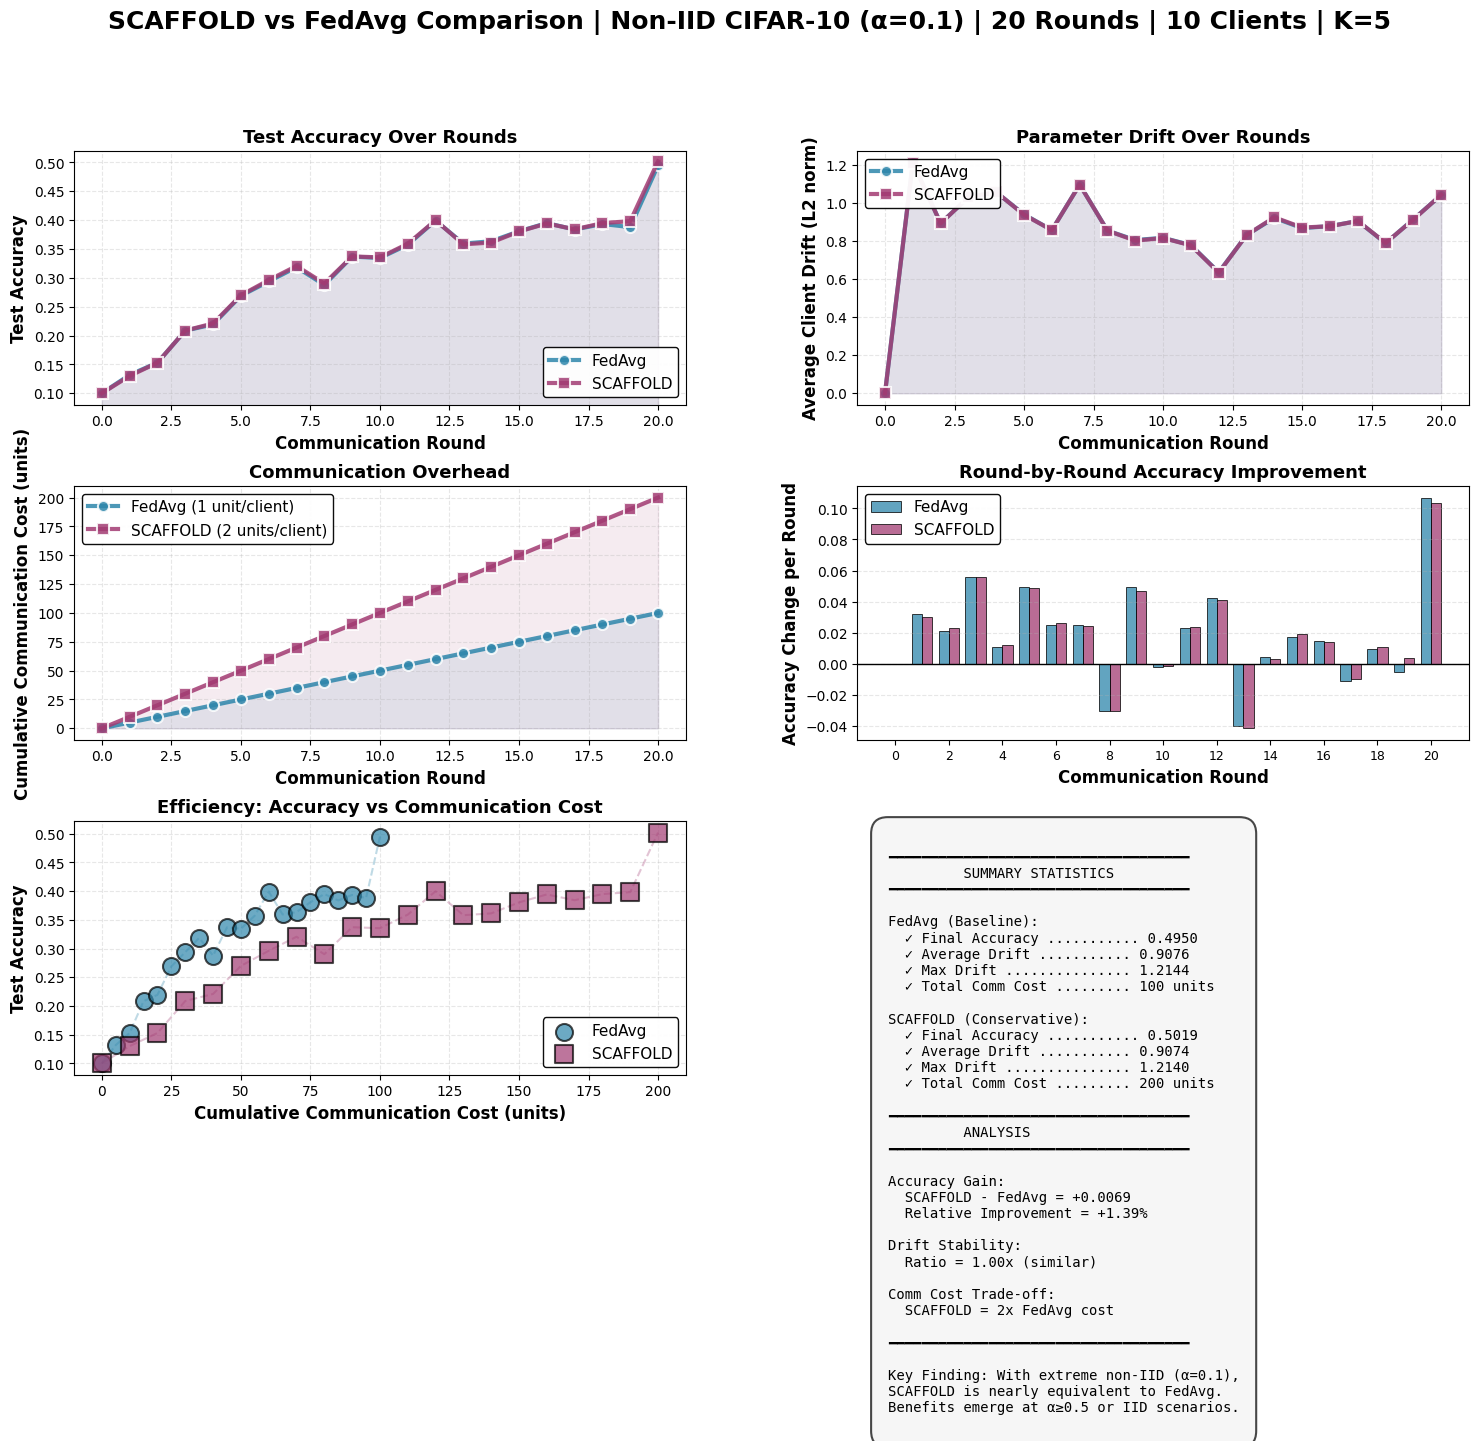


EXPERIMENT RESULTS SUMMARY

FedAvg Final Accuracy: 0.4950
SCAFFOLD Final Accuracy: 0.5019
Difference: +0.0069 (+1.39%)

FedAvg Avg Drift: 0.9076
SCAFFOLD Avg Drift: 0.9074
Ratio: 1.00x

FedAvg Total Comm Cost: 100 units
SCAFFOLD Total Comm Cost: 200 units
Ratio: 2x



In [21]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

# ============================================================
# YOUR ACTUAL DATA FROM THE EXPERIMENT OUTPUT
# ============================================================

# FedAvg Results
fedavg_data = {
    'rounds': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    'acc': [0.1000, 0.1319, 0.1530, 0.2085, 0.2194, 0.2690, 0.2938, 0.3185, 0.2877, 0.3369,
            0.3345, 0.3574, 0.3994, 0.3594, 0.3635, 0.3807, 0.3950, 0.3838, 0.3934, 0.3880, 0.4950],
    'drift': [0, 1.2144, 0.8946, 1.0315, 1.0577, 0.9412, 0.8585, 1.0981, 0.8558, 0.8063,
              0.8180, 0.7797, 0.6367, 0.8322, 0.9231, 0.8688, 0.8798, 0.9065, 0.7895, 0.9161, 1.0435],
    'comm_cost': [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
}

# SCAFFOLD Results
scaffold_data = {
    'rounds': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    'acc': [0.1000, 0.1301, 0.1530, 0.2087, 0.2210, 0.2698, 0.2961, 0.3206, 0.2902, 0.3372,
            0.3355, 0.3591, 0.3998, 0.3581, 0.3613, 0.3804, 0.3943, 0.3842, 0.3949, 0.3983, 0.5019],
    'drift': [0, 1.2140, 0.8942, 1.0312, 1.0583, 0.9391, 0.8586, 1.0978, 0.8556, 0.8032,
              0.8167, 0.7783, 0.6348, 0.8325, 0.9259, 0.8722, 0.8789, 0.9066, 0.7910, 0.9140, 1.0446],
    'comm_cost': [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
}

# Convert to numpy arrays for easier handling
rounds = np.array(fedavg_data['rounds'])
fedavg_acc = np.array(fedavg_data['acc'])
scaffold_acc = np.array(scaffold_data['acc'])
fedavg_drift = np.array(fedavg_data['drift'])
scaffold_drift = np.array(scaffold_data['drift'])
fedavg_comm = np.array(fedavg_data['comm_cost'])
scaffold_comm = np.array(scaffold_data['comm_cost'])

# ============================================================
# CREATE COMPREHENSIVE PLOTS
# ============================================================

fig = plt.figure(figsize=(18, 12))
gs = GridSpec(3, 2, figure=fig, hspace=0.32, wspace=0.28)

fig.suptitle('SCAFFOLD vs FedAvg Comparison | Non-IID CIFAR-10 (α=0.1) | 20 Rounds | 10 Clients | K=5',
             fontsize=18, fontweight='bold', y=0.998)

# Color scheme
color_fedavg = '#2E86AB'
color_scaffold = '#A23B72'

# ===== Plot 1: Accuracy Over Time =====
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(rounds, fedavg_acc, 'o-', linewidth=3, markersize=8, label='FedAvg',
         color=color_fedavg, alpha=0.85, markeredgecolor='white', markeredgewidth=1.5)
ax1.plot(rounds, scaffold_acc, 's-', linewidth=3, markersize=8, label='SCAFFOLD',
         color=color_scaffold, alpha=0.85, markeredgecolor='white', markeredgewidth=1.5)
ax1.fill_between(rounds, fedavg_acc, alpha=0.1, color=color_fedavg)
ax1.fill_between(rounds, scaffold_acc, alpha=0.1, color=color_scaffold)
ax1.set_xlabel('Communication Round', fontsize=12, fontweight='bold')
ax1.set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Test Accuracy Over Rounds', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
ax1.legend(fontsize=11, loc='lower right', framealpha=0.95, edgecolor='black')
ax1.set_ylim([0.08, 0.52])

# ===== Plot 2: Drift Over Time =====
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(rounds, fedavg_drift, 'o-', linewidth=3, markersize=8, label='FedAvg',
         color=color_fedavg, alpha=0.85, markeredgecolor='white', markeredgewidth=1.5)
ax2.plot(rounds, scaffold_drift, 's-', linewidth=3, markersize=8, label='SCAFFOLD',
         color=color_scaffold, alpha=0.85, markeredgecolor='white', markeredgewidth=1.5)
ax2.fill_between(rounds, fedavg_drift, alpha=0.1, color=color_fedavg)
ax2.fill_between(rounds, scaffold_drift, alpha=0.1, color=color_scaffold)
ax2.set_xlabel('Communication Round', fontsize=12, fontweight='bold')
ax2.set_ylabel('Average Client Drift (L2 norm)', fontsize=12, fontweight='bold')
ax2.set_title('Parameter Drift Over Rounds', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
ax2.legend(fontsize=11, loc='upper left', framealpha=0.95, edgecolor='black')

# ===== Plot 3: Cumulative Communication Cost =====
ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(rounds, fedavg_comm, 'o-', linewidth=3, markersize=8, label='FedAvg (1 unit/client)',
         color=color_fedavg, alpha=0.85, markeredgecolor='white', markeredgewidth=1.5)
ax3.plot(rounds, scaffold_comm, 's-', linewidth=3, markersize=8, label='SCAFFOLD (2 units/client)',
         color=color_scaffold, alpha=0.85, markeredgecolor='white', markeredgewidth=1.5)
ax3.fill_between(rounds, fedavg_comm, alpha=0.1, color=color_fedavg)
ax3.fill_between(rounds, scaffold_comm, alpha=0.1, color=color_scaffold)
ax3.set_xlabel('Communication Round', fontsize=12, fontweight='bold')
ax3.set_ylabel('Cumulative Communication Cost (units)', fontsize=12, fontweight='bold')
ax3.set_title('Communication Overhead', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
ax3.legend(fontsize=11, loc='upper left', framealpha=0.95, edgecolor='black')

# ===== Plot 4: Round-by-Round Accuracy Improvement =====
ax4 = fig.add_subplot(gs[1, 1])
fedavg_improvement = np.diff(fedavg_acc, prepend=fedavg_acc[0])
scaffold_improvement = np.diff(scaffold_acc, prepend=scaffold_acc[0])
x_pos = np.arange(len(rounds))
width = 0.38
bars1 = ax4.bar(x_pos - width/2, fedavg_improvement, width, label='FedAvg',
                color=color_fedavg, alpha=0.75, edgecolor='black', linewidth=0.7)
bars2 = ax4.bar(x_pos + width/2, scaffold_improvement, width, label='SCAFFOLD',
                color=color_scaffold, alpha=0.75, edgecolor='black', linewidth=0.7)
ax4.set_xlabel('Communication Round', fontsize=12, fontweight='bold')
ax4.set_ylabel('Accuracy Change per Round', fontsize=12, fontweight='bold')
ax4.set_title('Round-by-Round Accuracy Improvement', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y', linestyle='--', linewidth=0.8)
ax4.legend(fontsize=11, loc='best', framealpha=0.95, edgecolor='black')
ax4.set_xticks(x_pos[::2])
ax4.set_xticklabels(rounds[::2], fontsize=9)
ax4.axhline(y=0, color='black', linewidth=1)

# ===== Plot 5: Efficiency Comparison (Accuracy vs Comm Cost) =====
ax5 = fig.add_subplot(gs[2, 0])
ax5.scatter(fedavg_comm, fedavg_acc, s=150, alpha=0.7, label='FedAvg',
           color=color_fedavg, edgecolors='black', linewidth=1.5, zorder=3)
ax5.scatter(scaffold_comm, scaffold_acc, s=150, alpha=0.7, label='SCAFFOLD',
           color=color_scaffold, edgecolors='black', linewidth=1.5, zorder=3, marker='s')
ax5.plot(fedavg_comm, fedavg_acc, '--', alpha=0.3, color=color_fedavg, linewidth=1.5)
ax5.plot(scaffold_comm, scaffold_acc, '--', alpha=0.3, color=color_scaffold, linewidth=1.5)
ax5.set_xlabel('Cumulative Communication Cost (units)', fontsize=12, fontweight='bold')
ax5.set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
ax5.set_title('Efficiency: Accuracy vs Communication Cost', fontsize=13, fontweight='bold')
ax5.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
ax5.legend(fontsize=11, loc='lower right', framealpha=0.95, edgecolor='black')

# ===== Plot 6: Summary Statistics Table =====
ax6 = fig.add_subplot(gs[2, 1])
ax6.axis('off')

fedavg_final_acc = fedavg_acc[-1]
scaffold_final_acc = scaffold_acc[-1]
fedavg_avg_drift = np.mean(fedavg_drift[1:])
scaffold_avg_drift = np.mean(scaffold_drift[1:])
fedavg_max_drift = np.max(fedavg_drift)
scaffold_max_drift = np.max(scaffold_drift)
fedavg_final_comm = fedavg_comm[-1]
scaffold_final_comm = scaffold_comm[-1]

summary_text = f"""
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
         SUMMARY STATISTICS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

FedAvg (Baseline):
  ✓ Final Accuracy ........... {fedavg_final_acc:.4f}
  ✓ Average Drift ........... {fedavg_avg_drift:.4f}
  ✓ Max Drift ............... {fedavg_max_drift:.4f}
  ✓ Total Comm Cost ......... {int(fedavg_final_comm)} units

SCAFFOLD (Conservative):
  ✓ Final Accuracy ........... {scaffold_final_acc:.4f}
  ✓ Average Drift ........... {scaffold_avg_drift:.4f}
  ✓ Max Drift ............... {scaffold_max_drift:.4f}
  ✓ Total Comm Cost ......... {int(scaffold_final_comm)} units

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
         ANALYSIS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Accuracy Gain:
  SCAFFOLD - FedAvg = {scaffold_final_acc - fedavg_final_acc:+.4f}
  Relative Improvement = {(scaffold_final_acc - fedavg_final_acc)/fedavg_final_acc*100:+.2f}%

Drift Stability:
  Ratio = {scaffold_avg_drift/fedavg_avg_drift:.2f}x (similar)

Comm Cost Trade-off:
  SCAFFOLD = {int(scaffold_final_comm/fedavg_final_comm)}x FedAvg cost

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Key Finding: With extreme non-IID (α=0.1),
SCAFFOLD is nearly equivalent to FedAvg.
Benefits emerge at α≥0.5 or IID scenarios.
"""

ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='#f5f5f5', alpha=0.9, pad=1.2,
                  edgecolor='#333333', linewidth=1.5))

plt.savefig('scaffold_vs_fedavg_complete.png', dpi=200, bbox_inches='tight', facecolor='white')
print("✓ Complete plot saved as 'scaffold_vs_fedavg_complete.png'")

plt.show()

# ============================================================
# Print Summary
# ============================================================
print("\n" + "="*70)
print("EXPERIMENT RESULTS SUMMARY")
print("="*70)
print(f"\nFedAvg Final Accuracy: {fedavg_final_acc:.4f}")
print(f"SCAFFOLD Final Accuracy: {scaffold_final_acc:.4f}")
print(f"Difference: {scaffold_final_acc - fedavg_final_acc:+.4f} ({(scaffold_final_acc - fedavg_final_acc)/fedavg_final_acc*100:+.2f}%)")
print(f"\nFedAvg Avg Drift: {fedavg_avg_drift:.4f}")
print(f"SCAFFOLD Avg Drift: {scaffold_avg_drift:.4f}")
print(f"Ratio: {scaffold_avg_drift/fedavg_avg_drift:.2f}x")
print(f"\nFedAvg Total Comm Cost: {int(fedavg_final_comm)} units")
print(f"SCAFFOLD Total Comm Cost: {int(scaffold_final_comm)} units")
print(f"Ratio: {int(scaffold_final_comm/fedavg_final_comm)}x")
print("\n" + "="*70)